In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

# Step 1 : Data to work on

In [2]:
with open("mega.txt", "r", encoding="utf-8") as f:
    text_data = f.read()
print("Total number of character:", len(text_data))

Total number of character: 57004


In [3]:
print(text_data[:10000])

Molecular Biology and Evolution, 2024, 41, 1–9
https://doi.org/10.1093/molbev/msae263
Advance access publication 21 December 2024
Resources
                                                                                                                                       MBE
MEGA12: Molecular Evolutionary Genetic Analysis Version
12 for Adaptive and Green Computing




                                                                                                                                                               Downloaded from https://academic.oup.com/mbe/article/41/12/msae263/7930299 by Temple University Law School Library user on 11 June 2025
Sudhir Kumar ,1,2,* Glen Stecher,1 Michael Suleski,1 Maxwell Sanderford,1 Sudip Sharma                                                                 ,1,2
Koichiro Tamura 3,4
1
  Institute for Genomics and Evolutionary Medicine, Temple University, Philadelphia, PA 19122, USA
2
  Department of Biology, Temple University, Philade

# Step 2 : Tokenise the given input

<div class="alert alert-block alert-success">

#### A naive way is to tokenize the data is to either break on the spaces but that would result in not very efficient tokenization for example if we have 2 words like "boy" and  "boys", they will be treated as 2 separate tokens. Even if they are close in meaning, they will be represented as 2 separate tokens. Also, it is difficult to handle OOV (Out-of-Vocabulary) text using the above technique and the dictionary can be as big as it can get. This is called Word based tokenization

#### Another way can be to break the text into characters. This solves the OOV problem as there are definte characters in English language. But, the semantic meaning and ordering is completely lost. Also, the tokenized sequence is much longer than the original text. This is called Character based tokenization

#### Therefore, all the big LLM companies use Sub-word based tokenization techniques. For example Byte Pair Encoding. The frequent pair of characters will appear together. More information on the link : https://github.com/openai/tiktoken

</div>

In [4]:
#! pip3 install tiktoken

In [5]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.9.0


In [6]:
tokenizer = tiktoken.get_encoding("gpt2")

In [7]:
#EXAMPLE
text = ("Would you like this turned into a weekly plan to follow over 2–3 months?")
token_IDs = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
print(token_IDs)

string = tokenizer.decode(token_IDs)
print(string)

[17353, 345, 588, 428, 2900, 656, 257, 10273, 1410, 284, 1061, 625, 362, 1906, 18, 1933, 30]
Would you like this turned into a weekly plan to follow over 2–3 months?


In [8]:
#APPLY THE TIKTOKEN TOKENIZER ON OUR DATA
data_tokens = tokenizer.encode(text_data)

In [9]:
print(tokenizer.decode(data_tokens))

Molecular Biology and Evolution, 2024, 41, 1–9
https://doi.org/10.1093/molbev/msae263
Advance access publication 21 December 2024
Resources
                                                                                                                                       MBE
MEGA12: Molecular Evolutionary Genetic Analysis Version
12 for Adaptive and Green Computing




                                                                                                                                                               Downloaded from https://academic.oup.com/mbe/article/41/12/msae263/7930299 by Temple University Law School Library user on 11 June 2025
Sudhir Kumar ,1,2,* Glen Stecher,1 Michael Suleski,1 Maxwell Sanderford,1 Sudip Sharma                                                                 ,1,2
Koichiro Tamura 3,4
1
  Institute for Genomics and Evolutionary Medicine, Temple University, Philadelphia, PA 19122, USA
2
  Department of Biology, Temple University, Philade

In [10]:
print(len(data_tokens))
print(len(set(data_tokens)))

22792
2352


<div class="alert alert-block alert-success">

#### The 5000 tokens we got after tokenizing out personal data are not necessarily our vocabulary. They are the token instances (i.e., a stream of token IDs), not the vocabulary (i.e., the set of all unique tokens our tokenizer knows about).
    
#### Vocabulary is the complete set of unique tokens that the tokenizer (tiktoken) can recognize. If we are using a tokenizer like tiktoken.get_encoding("gpt2"), its vocabulary size is fixed — 50,257 tokens in GPT-2's case. These include individual characters, subwords, or words, depending on the tokenizer training.
    
#### If we are training a Transformer From Scratch: There are two ways to go about it depending on what we are trying to achieve:

#### Option 1: Use a Pretrained Tokenizer (tiktoken)
#### Option 2: Want a Custom Vocabulary (train your own tokenizer)   

</div>

# Step 3 : Finalise the Input-Output Target pairs

<div class="alert alert-block alert-success">

#### So basically, training the LLM is like training an autoregressive model. Sentence structure is used for training. There are no labels and for the same reason it is called unsupervised learning.
    
#### Here, we introduce the concept of Context Window / Size i.e. the number of words / tokens that will be used to predict the next one.
    
#### For eg. text "Hardik Sharma is a good boy." If the context window is 4, that means "Hardik Sharma is a" will be used to predict "good". "Sharma is a good" will be used to predict "boy". 
    
#### For any given input with a context length length, the output will be another sequence just shifted by one.

</div>

In [11]:
#EXAMPLE
text = "Hardik Sharma is a good boy"
text=text.split()
context_size = 4 
print("INPUT-->", text[:context_size])
print("OUTPUT-->", text[1:context_size+1])

print("-------------------------------------------")
# Each of the given is a prediction ask in itself.
for i in range(len(text)-1):
    print(f"{text[:i+1]} ---> {text[i+1]}")

# We need to extract the given input-output pairs from our input text. 
# We will also introduce the concept of batches here.

INPUT--> ['Hardik', 'Sharma', 'is', 'a']
OUTPUT--> ['Sharma', 'is', 'a', 'good']
-------------------------------------------
['Hardik'] ---> Sharma
['Hardik', 'Sharma'] ---> is
['Hardik', 'Sharma', 'is'] ---> a
['Hardik', 'Sharma', 'is', 'a'] ---> good
['Hardik', 'Sharma', 'is', 'a', 'good'] ---> boy


In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn

In [13]:
# DATASET CLASS USED FOR LOADING THE DATA
class CustomDataset(Dataset):
    
    # METHOD 1 : HOW AND WHERE THE DATA SHOULD BE LOADED
    def __init__(self, text_data, tokenizer, context_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(text_data, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - context_length, stride):
            input_chunk = token_ids[i:i + context_length]
            target_chunk = token_ids[i + 1: i + context_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
    # METHOD 2 : GIVE THE TOTAL NUMBER OF BATCHES 
    def __len__(self):
        return len(self.input_ids)
    
    # METHOD 3 : USED FOR FETCHING INFORMATION
    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]

In [14]:
# DATASETLOADER CLASS USED FOR CREATING THE BATCHES
# I just create a function here which will automatically define our dataset as well as dataloader

def make_dataloader(text_data, batch_size=4, context_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    
    tokenizer = tiktoken.get_encoding("gpt2")
    
    dataset = CustomDataset(text_data, tokenizer, context_length, stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    return dataloader

In [15]:
dataloader = make_dataloader(text_data, batch_size=1, context_length=5, stride=5)

In [16]:
# TESTING
data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch) # prints the input batch and the output batch

[tensor([[14567,   329,  1449, 21319,   290]]), tensor([[  329,  1449, 21319,   290, 16287]])]


In [17]:
dataloader = make_dataloader(text_data, batch_size=4, context_length=5, stride=5)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[  530,   286,   262,   198,    83],
        [  220,   220,   220, 48609,    25],
        [  220,   220,   220,   220,   220],
        [  583, 11111,   357,  6322,    40]])

Targets:
 tensor([[  286,   262,   198,    83,  1009],
        [  220,   220, 48609,    25,  3901],
        [  220,   220,   220,   220,   220],
        [11111,   357,  6322,    40,     8]])


# Step 4 : Create the input embeddings

<div class="alert alert-block alert-success">

#### For each token ID, we will represent them in a 'n' dimensional embedding vector. The embedding weights are initialized randomly which serves as the starting point for our LLM learning process. The embedding weights are optimized as a part of training process
</div>

<div class="alert alert-block alert-info">

#### THINK OF EMBEDDING WEIGHT LAYER AS A LOOKUP MATRIX THAT CONTAINS EMBEDDING LAYER FOR EACH TOKEN ID. THEREFORE, THE DIMENSION OF AN EMBEDDING MATRIX = Number of token ids x 'n' Dimension. 
</div>

In [18]:
#EXAMPLE : WE HAVE 5 TOKENS, EACH IS REPRESENT THROUGH A 5 DIMENSION VECTOR

num_tokens = 5 # For eg. "Hardik","is","a","good","boy"
embedding_dim = 5
embedding_matrix = torch.nn.Embedding(num_tokens, embedding_dim)

print(embedding_matrix.weight)

Parameter containing:
tensor([[ 0.9978,  1.0415,  2.0103,  0.0099, -2.1790],
        [ 0.9618, -0.6465,  0.5149, -1.8752,  0.6310],
        [ 1.1875,  0.2682, -1.5297, -0.4929, -1.7336],
        [ 0.0338, -2.3538,  2.6719,  2.7228,  1.8366],
        [ 0.3175, -1.0971,  0.3268, -1.2724, -0.7179]], requires_grad=True)


In [19]:
token_id = torch.tensor([3])
print(embedding_matrix(token_id))

tensor([[ 0.0338, -2.3538,  2.6719,  2.7228,  1.8366]],
       grad_fn=<EmbeddingBackward0>)


<div class="alert alert-block alert-success">

#### Since we have 50257 tokens in our vocabulary (Tiktoken GPT2 vocabulary), the num_tokens = 50257.
#### Let's start with the embedding_dim to be 128, i.e. each token will be represented as a 128 dimension vector.    
</div>

In [20]:
num_tokens = 50257
embedding_dim = 128
embedding_matrix = torch.nn.Embedding(num_tokens, embedding_dim)
print(embedding_matrix)

Embedding(50257, 128)


<div class="alert alert-block alert-info">

#### Using the embedding_matrix above, if we sample data from the data loader, we embed each token in each batch into a 128-dimensional vector. If we have a batch size of 4 with 5 tokens each, the result will be an 4 x 5 x 128 tensor.
    
</div>

In [21]:
dataloader = make_dataloader(text_data, batch_size=4, context_length=5, stride=5)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [22]:
token_embeddings = embedding_matrix(inputs)
print(token_embeddings.shape)

torch.Size([4, 5, 128])


# Step 5 : Create the positional embeddings

<div class="alert alert-block alert-success">

#### Untill now, we converted the input sequence into vectors, but we didn't account for each tokens position inside the sentence. Let us work on that.
#### Positional embeddings can be 1. Absolute 2. Relative
    
#### Absolute are used when fixed order of tokens is crucial like sequence generation. Relative embeddings are used when performing language modelling, over long sequences where some phrase can appear in different parts of the sequence.
    
#### Positional encodings are always of size context length x embedding dimension

</div>

In [23]:
embedding_dim = 128
context_length = 5

In [24]:
pos_embedding_layer = torch.nn.Embedding(context_length, embedding_dim)
pos_embeddings = pos_embedding_layer(torch.arange(context_length))
print(pos_embeddings.shape)

torch.Size([5, 128])


In [25]:
# INPUT EMBEDDINGS = TOKEN_EMBEDDINGS + POSITIONAL_EMBEDDINGS
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

torch.Size([4, 5, 128])


# Step 6 : Transformer Block

## Step 6.1 : Self Attention without trainable weights

In [26]:
import torch
inputs = torch.tensor( 
  [[0.43, 0.15, 0.89],  # HARDIK    
   [0.55, 0.87, 0.66],  # IS  
   [0.57, 0.85, 0.64],  # A   
   [0.22, 0.58, 0.33],  # GOOD     
   [0.77, 0.25, 0.10]]  # BOY    
)
# Input Shape 5 X 3
# Self Attention shape 5 X 5

<div class="alert alert-block alert-success">

#### Self attention is a mechanism that allows each position of the input sequence to attend to all positions in the same sequence when computing the respresentation.
    
</div>

In [27]:
self_attention_score = inputs @ inputs.T
print(self_attention_score)
print(self_attention_score.shape)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654]])
torch.Size([5, 5])


<div class="alert alert-block alert-success">

#### Next, we normalize the attentions scores so that they add upto 1. It is useful for interpretation and also for maintaining the stability in an LLM. Simplest way is to sum up the total and divide by the total but it is advisable to use softmax function from the torch.

#### In the context of using PyTorch, the dim parameter in functions like torch.softmax specifies the dimension of the input tensor along which the function will be computed. By setting dim=-1, we are instructing the softmax function to apply the normalization along the last dimension of the attn_scores tensor. If attn_scores is a 2D tensor (for example, with a shape of [rows, columns]), dim=-1 will normalize across the columns so that the values in each row (summing over the column dimension) sum up to 1.
    
</div>

In [28]:
self_attention_weights = torch.softmax(self_attention_score, dim=-1)
print(self_attention_weights)

tensor([[0.2455, 0.2346, 0.2318, 0.1453, 0.1428],
        [0.1646, 0.2826, 0.2771, 0.1473, 0.1285],
        [0.1648, 0.2809, 0.2757, 0.1472, 0.1314],
        [0.1733, 0.2505, 0.2471, 0.1766, 0.1525],
        [0.1753, 0.2250, 0.2269, 0.1570, 0.2158]])


<div class="alert alert-block alert-success">

#### Context vector for our input is self attention weights x input
</div>

In [29]:
context_vector = self_attention_weights @ inputs
print(context_vector)

tensor([[0.5086, 0.5580, 0.5839],
        [0.5155, 0.6236, 0.5717],
        [0.5160, 0.6217, 0.5702],
        [0.5094, 0.5945, 0.5512],
        [0.5292, 0.5599, 0.5231]])


<div class="alert alert-block alert-info">

#### Currently the above attention mechanism is without any trainable weights. Just random static values. This is not an effective approach. In the next section we will introduce attention mechanism is with trainable weights. We will introduce 3 matrices namely Query, Key and Value.
    
</div>

## Step 6.2 : Self Attention with trainable weights

<div class="alert alert-block alert-info">

#### Each of the above weight matrices Query, Key and Value the dimension is input_dim x output_dim. Input_dim is generally equal to the vector dimension of input. The output_dim can be anything. Generally it is equal to the input_dim 
    
</div>

In [30]:
inputs = torch.tensor( 
  [[0.43, 0.15, 0.89],  # HARDIK    
   [0.55, 0.87, 0.66],  # IS  
   [0.57, 0.85, 0.64],  # A   
   [0.22, 0.58, 0.33],  # GOOD     
   [0.77, 0.25, 0.10]]  # BOY    
)

In [31]:
input_dim = 3
output_dim = 3

In [32]:
W_query = torch.nn.Parameter(torch.rand(input_dim, output_dim), requires_grad=False)
W_key = torch.nn.Parameter(torch.rand(input_dim, output_dim), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(input_dim, output_dim), requires_grad=False)

In [33]:
W_query, W_key, W_value

(Parameter containing:
 tensor([[0.2428, 0.9517, 0.1209],
         [0.8577, 0.6965, 0.5769],
         [0.5285, 0.7489, 0.4559]]),
 Parameter containing:
 tensor([[0.1399, 0.3710, 0.1960],
         [0.8147, 0.9836, 0.9322],
         [0.1146, 0.3451, 0.7438]]),
 Parameter containing:
 tensor([[0.0768, 0.2979, 0.5673],
         [0.5852, 0.8943, 0.4426],
         [0.7718, 0.4632, 0.0711]]))

In [34]:
Queries = inputs @ W_query
Keys = inputs @ W_key
Values = inputs @ W_value

print("Keys.shape:", Keys.shape)
print("Values.shape:", Values.shape)
print("Queries.shape:", Queries.shape)

Keys.shape: torch.Size([5, 3])
Values.shape: torch.Size([5, 3])
Queries.shape: torch.Size([5, 3])


In [35]:
d_k = Keys.shape[-1]
self_attention_score = ((Queries @ Keys.T)/d_k**0.5)

In [36]:
self_attention_score.shape

torch.Size([5, 5])

In [37]:
self_attention_weights = torch.softmax(self_attention_score, dim=-1)

In [38]:
context_vector = self_attention_weights @ inputs
print(context_vector)

tensor([[0.5132, 0.6563, 0.5698],
        [0.5192, 0.7084, 0.5896],
        [0.5189, 0.7065, 0.5889],
        [0.5113, 0.6402, 0.5636],
        [0.5110, 0.6240, 0.5561]])


### Step 6.2.1 : Summarize the above steps in a single class

In [39]:
class SelfAttention(nn.Module):
    def __init__(self, input_dim, output_dim, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(input_dim, output_dim, bias=qkv_bias)
        self.W_key   = nn.Linear(input_dim, output_dim, bias=qkv_bias)
        self.W_value = nn.Linear(input_dim, output_dim, bias=qkv_bias)

    def forward(self, inputs):
        Queries = self.W_query(inputs)
        Keys = self.W_key(inputs)
        Values = self.W_value(inputs)
        
        self_attention_score = Queries @ Keys.T
        self_attention_weights = torch.softmax(self_attention_score / Keys.shape[-1]**0.5, dim=-1)

        context_vector = self_attention_weights @ Values
        return context_vector

In [40]:
self_attention = SelfAttention(input_dim, output_dim)
print(self_attention(inputs))

tensor([[-0.1150,  0.0186, -0.0135],
        [-0.1192,  0.0206, -0.0111],
        [-0.1191,  0.0206, -0.0113],
        [-0.1145,  0.0196, -0.0157],
        [-0.1138,  0.0213, -0.0193]], grad_fn=<MmBackward0>)


## Step 6.3 : Adding Causal Attention mechanism for our architecture

In [41]:
context_length = 5
mask = torch.triu(torch.ones([context_length,context_length]), diagonal=1)

In [42]:
mask

tensor([[0., 1., 1., 1., 1.],
        [0., 0., 1., 1., 1.],
        [0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0.]])

In [43]:
print(self_attention_score)

tensor([[0.8124, 1.6702, 1.6414, 1.0023, 0.6609],
        [1.2222, 2.5256, 2.4815, 1.5181, 0.9897],
        [1.2056, 2.4920, 2.4486, 1.4979, 0.9774],
        [0.6860, 1.4168, 1.3920, 0.8521, 0.5518],
        [0.5675, 1.1860, 1.1662, 0.7116, 0.4804]])


In [44]:
masked_self_attention_score = self_attention_score.masked_fill(mask.bool(), -torch.inf)
print(masked_self_attention_score)

tensor([[0.8124,   -inf,   -inf,   -inf,   -inf],
        [1.2222, 2.5256,   -inf,   -inf,   -inf],
        [1.2056, 2.4920, 2.4486,   -inf,   -inf],
        [0.6860, 1.4168, 1.3920, 0.8521,   -inf],
        [0.5675, 1.1860, 1.1662, 0.7116, 0.4804]])


In [45]:
masked_self_attention_weights = torch.softmax(masked_self_attention_score / Keys.shape[-1]**0.5, dim=1)
print(masked_self_attention_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3203, 0.6797, 0.0000, 0.0000, 0.0000],
        [0.1941, 0.4080, 0.3979, 0.0000, 0.0000],
        [0.1950, 0.2973, 0.2931, 0.2146, 0.0000],
        [0.1701, 0.2431, 0.2403, 0.1848, 0.1617]])


In [46]:
## WE ALSO ADD DROPUT IN THE GIVEN ARCHITECTURE AS IT PREVENTS OVERFITTING BY MASKING RANDOM POSITIONS
dropout = nn.Dropout(p=0.5)

In [47]:
temp = dropout(masked_self_attention_weights)

### Step 6.3.1 : Summarize the above causal attention steps in a single class

In [48]:
class CausalAttention(nn.Module):
    def __init__(self, input_dim, output_dim, context_length, p, qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(input_dim, output_dim, bias=qkv_bias)
        self.W_key   = nn.Linear(input_dim, output_dim, bias=qkv_bias)
        self.W_value = nn.Linear(input_dim, output_dim, bias=qkv_bias)
        self.dropout = nn.Dropout(p)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, inputs):
        Queries = self.W_query(inputs)
        Keys = self.W_key(inputs)
        Values = self.W_value(inputs)
        
        batch, num_tokens, input_dim = inputs.shape
        print(f"Batches = {batch}, Context Size = {num_tokens}, Embedding dimension = {input_dim}")
        self_attention_score = Queries @ Keys.transpose(1,2)
        
        masked_self_attention_score = self_attention_score.masked_fill(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        masked_self_attention_weights = torch.softmax(masked_self_attention_score / Keys.shape[-1]**0.5, dim=-1)
        masked_self_attention_weights = self.dropout(masked_self_attention_weights)
        
        context_vector = masked_self_attention_weights @ Values
        return context_vector

In [49]:
## TESTING OUR CLASS WITH A TEST INPUT OF Batches = 2, Context Size = 3, Embedding dimension = 5
test_input = torch.rand(2,3,5)

In [50]:
test_input

tensor([[[0.2367, 0.6611, 0.9241, 0.5598, 0.5368],
         [0.4707, 0.0966, 0.8298, 0.6292, 0.5655],
         [0.6974, 0.2714, 0.3311, 0.5154, 0.8852]],

        [[0.8127, 0.7228, 0.9167, 0.7630, 0.6656],
         [0.4599, 0.1709, 0.2292, 0.7050, 0.0946],
         [0.1564, 0.0611, 0.6763, 0.9193, 0.1807]]])

In [51]:
input_dim = 5
output_dim = 5
context_length = 3
p = 0.5
causalattention = CausalAttention(input_dim,output_dim,context_length,p)

In [52]:
cv = causalattention(test_input)
print(cv)

Batches = 2, Context Size = 3, Embedding dimension = 5
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [-0.1723,  0.4552, -0.1450,  0.0111, -0.6443],
         [-0.1902,  0.2381,  0.0229, -0.0514, -0.4299]],

        [[-0.4189,  1.0184, -0.0397, -0.0673, -1.5546],
         [-0.0317,  0.3413, -0.2110,  0.2650, -0.2990],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]]],
       grad_fn=<UnsafeViewBackward0>)


<div class="alert alert-block alert-info">

#### The outputs acheived from the above causal attention class can be considered as an output from 1 head. If we carry this out for multiple times, that is, multiple heads, it is called multi-head attention. 
    
</div>

## Step 6.4 : Adding naive Multi-head Attention mechanism for our architecture

<div class="alert alert-block alert-info">

#### In the following code, we can achieve a naive MultiHeadAttention class by stacking multiple instances of our CausalAttention class module
    
</div>

In [53]:
class MultiHeadAttentionNaive(nn.Module):

    def __init__(self, input_dim, output_dim, context_length, p, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(input_dim, output_dim, context_length, p, qkv_bias) 
             for _ in range(num_heads)]
        )

    def forward(self, inputs):
        return torch.cat([head(inputs) for head in self.heads], dim=-1)

In [54]:
input_dim = 5
output_dim = 5
context_length = 3
p = 0.5
num_heads = 2
multiheadattention = MultiHeadAttentionNaive(input_dim,output_dim,context_length,p, num_heads)
mha = multiheadattention(test_input)
print(mha)
print(mha.shape)

## THE FINAL CONTEXT VECTOR WILL OF THE DIMENSION (BATCH x CONTEXT_LENGTH x EMBEDDING DIMENSION*NUM_HEADS)

Batches = 2, Context Size = 3, Embedding dimension = 5
Batches = 2, Context Size = 3, Embedding dimension = 5
tensor([[[-1.0645,  0.1453,  0.3904, -0.1668, -0.0453,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000],
         [-0.5353,  0.0731,  0.1963, -0.0839, -0.0228, -0.4796, -0.1422,
           0.3841,  0.0086,  0.1783],
         [-0.4199,  0.0559,  0.3297, -0.1728, -0.0359, -0.9099, -0.3962,
           0.6297,  0.1122, -0.2356]],

        [[-1.0958, -0.1064,  0.7098, -0.4348, -0.0073, -0.9322, -0.4943,
           0.9065, -0.0907, -0.1938],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.4191, -0.2222,
           0.4075, -0.0408, -0.0871],
         [-0.5532,  0.0020,  0.4718, -0.2133,  0.0884, -0.8454, -0.4479,
           0.4909, -0.2812,  0.0110]]], grad_fn=<CatBackward0>)
torch.Size([2, 3, 10])


<div class="alert alert-block alert-info">

#### The above class does the job for us, but this is not optimal as the above will run sequentially but we want parallel execution of our code.
    
</div>

<div class="alert alert-block alert-info">
    
#### Instead of maintaining two separate classes, MultiHeadAttention and CausalAttention, we can combine both of these concepts into a single MultiHeadAttention class. Also, in addition to just merging the MultiHeadAttentionWrapper with the CausalAttention code, we will make some other modifications to implement multi-head attention more efficiently.
    
#### In the MultiHeadAttentionWrapper, multiple heads are implemented by creating a list of CausalAttention objects (self.heads), each representing a separate attention head. The CausalAttention class independently performs the attention mechanism, and the results from each head are concatenated. In contrast, the following MultiHeadAttention class integrates the multi-head functionality within a single class. It splits the input into multiple heads by reshaping the projected query, key, and value tensors and then combines the results from these heads after computing attention.
</div>

In [55]:
## BEFORE FEEDING INPUT INTO THE MULTI-HEAD ATTENTION CLASS DECIDE THE FOLLOWING 2 THINGS:
## OUTPUT_DIM AND NUM_HEADS
## THERE IS FORMULA FOR CALCULATING HEAD DIMENSION = OUTPUT_DIM / NUM_HEADS
## THEREFORE, THE OUTPUT_DIM % NUM_HEADS = 0

In [56]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, output_dim, context_length, p, num_heads, qkv_bias=False):
        super().__init__()
        assert (output_dim % num_heads == 0), \
            "output_dim must be divisible by num_heads"

        self.output_dim = output_dim
        self.num_heads = num_heads
        self.head_dim = output_dim // num_heads
        
        self.W_query = nn.Linear(input_dim, output_dim, bias=qkv_bias)
        self.W_key   = nn.Linear(input_dim, output_dim, bias=qkv_bias)
        self.W_value = nn.Linear(input_dim, output_dim, bias=qkv_bias)
        self.Output_Projection = nn.Linear(output_dim, output_dim) 
        self.dropout = nn.Dropout(p)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))
    
    def forward(self, inputs):
        batch, num_tokens, input_dim = inputs.shape
        
        Queries = self.W_query(inputs)
        Keys = self.W_key(inputs)
        Values = self.W_value(inputs)
        
        Keys = Keys.view(batch, num_tokens, self.num_heads, self.head_dim) 
        Queries = Queries.view(batch, num_tokens, self.num_heads, self.head_dim)
        Values = Values.view(batch, num_tokens, self.num_heads, self.head_dim)

        Keys = Keys.transpose(1, 2)
        Queries = Queries.transpose(1, 2)
        Values = Values.transpose(1, 2)

        self_attention_score = Queries @ Keys.transpose(2, 3) 


        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        masked_self_attention_score = self_attention_score.masked_fill_(mask_bool, -torch.inf)
        
        masked_self_attention_weights = torch.softmax(masked_self_attention_score / Keys.shape[-1]**0.5, dim=-1)
        masked_self_attention_weights = self.dropout(masked_self_attention_weights)

        context_vector = (masked_self_attention_weights @ Values).transpose(1, 2) 
        
        context_vector = context_vector.contiguous().view(batch, num_tokens, self.output_dim)
        context_vector = self.Output_Projection(context_vector) # optional projection

        return context_vector

<div class="alert alert-block alert-info">

#### Step 1: Reduce the projection dim to match desired output dim

#### Step 2: Use a Linear layer to combine head outputs

#### Step 3: Tensor shape: (batch,num_tokens, output_dim)

#### Step 4: We implicitly split the matrix by adding a "num_heads" dimension. Then we unroll last dim: (batch,num_tokens, output_dim) -> (batch, num_tokens, num_heads, head_dim)

#### Step 5: Transpose from shape (batch, num_tokens, num_heads, head_dim) to (batch, num_heads, num_tokens, head_dim)

#### Step 6: Compute dot product for each head

#### Step 7: Mask truncated to the number of tokens

#### Step 8: Use the mask to fill attention scores

#### Step 9: Tensor shape: (batch, num_tokens, n_heads, head_dim)

#### Step 10: Combine heads, where self.output_dim = self.num_heads * self.head_dim

#### Step 11: Add an optional linear projection
</div>

In [57]:
test_input = torch.rand(2,3,6)

In [58]:
input_dim = 6
output_dim = 6
context_length = 3
p = 0.5
num_heads = 2
multiheadattention = MultiHeadAttention(input_dim,output_dim,context_length,p, num_heads)
mha = multiheadattention(test_input)
print(mha)
print(mha.shape)

tensor([[[ 0.1718, -0.1055, -0.3672, -0.0650,  0.2676,  0.0720],
         [ 0.4229, -0.2793, -0.3730, -0.0273,  0.3053, -0.0127],
         [ 0.2311, -0.1652, -0.3586, -0.0664,  0.2687,  0.0118]],

        [[ 0.2365, -0.2665, -0.4015,  0.1143,  0.5299,  0.1356],
         [ 0.4784, -0.3644, -0.2417, -0.0920,  0.1963,  0.1256],
         [ 0.5203, -0.4821, -0.2122,  0.0179,  0.3599,  0.1866]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 3, 6])


In [59]:
## NOW THAT WE HAVE CODED OUR ENTIRE MULTIHEAD ATTENTION CLASS. LET US CREATE OTHER COMPONENTS.
## OTHER COMPONENTS : LAYER NORMALISATION, FEEDFORWARD, DROPOUT AND RESIDUAL CONNECTIONS

## Step 6.5 : Create a Configuration for  smalLM

In [60]:
smalLM_config= {
    "vocab_size": 50257,          # Vocabulary size
    "context_length": 100,        # Context length
    "embedding_dim": 100,         # Embedding dimension
    "num_heads": 1,               # Number of attention heads
    "num_layers": 1,              # Number of layers
    "dropout_rate": 0.5,          # Dropout rate
    "qkv_bias": False             # Query-Key-Value bias
}

## Step 6.6 : Coding the LayerNomalization Class

<div class="alert alert-block alert-info">

#### The following implementation of Layer Normalization operates on the last dimension of the input tensor, which represents the embedding dimension (embedding_dim). The variable eps is a small constant (epsilon) added to the variance to prevent division by zero during normalization. The scale and shift are two trainable parameters (of the same dimension as the input) that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task. This allows the model to learn appropriate scaling and shifting that best suit the data it is processing.

</div>

In [61]:
class LayerNomalization(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.eps =  1e-7
        self.scale = nn.Parameter(torch.ones(embedding_dim))
        self.shift = nn.Parameter(torch.zeros(embedding_dim))
        
    def forward(self, inputs):
        mean = inputs.mean(dim=-1, keepdim=True)
        var = inputs.var(dim=-1, keepdim=True, unbiased=False)
        normalized_inputs = (inputs - mean) / torch.sqrt(var + self.eps)
        return self.scale * normalized_inputs + self.shift

In [62]:
test_input = torch.rand(2, 2, 3)

In [63]:
test_input

tensor([[[0.0243, 0.4137, 0.4180],
         [0.6813, 0.0193, 0.7872]],

        [[0.3561, 0.3991, 0.7984],
         [0.4015, 0.3860, 0.3515]]])

In [64]:
ln = LayerNomalization(embedding_dim=3)
print(ln(test_input))

tensor([[[-1.4141,  0.6954,  0.7188],
         [ 0.5455, -1.4027,  0.8572]],

        [[-0.8123, -0.5965,  1.4087],
         [ 1.0439,  0.3041, -1.3480]]], grad_fn=<AddBackward0>)


## Step 6.6 : Coding the Feed Forward Layer Class

<div class="alert alert-block alert-info">

#### FeedForward module is a small neural network consisting of two Linear layers and a GELU activation function.

</div>

### Step 6.6.1 : GeLU activation token

In [65]:
class GeLU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, inputs):
        gelu = 0.5 * inputs * (1 + torch.tanh(torch.sqrt(torch.tensor(2/torch.pi)) * 
                                              (inputs + 0.044715*torch.pow(inputs,3))))
        return gelu

In [66]:
gelu = GeLU()

In [67]:
print(gelu(test_input))

tensor([[[0.0124, 0.2732, 0.2768],
         [0.5124, 0.0098, 0.6175]],

        [[0.2276, 0.2614, 0.6288],
         [0.2633, 0.2510, 0.2240]]])


### Step 6.6.2 : Feed Forward Layer class

In [68]:
class FeedForward(nn.Module):
    def __init__(self,config_dict):
        super().__init__()
        self.layers = nn.Sequential(
        nn.Linear(config_dict["embedding_dim"], 4*config_dict["embedding_dim"]),
        GeLU(),
        nn.Linear(4*config_dict["embedding_dim"],config_dict["embedding_dim"]),
        )
    
    def forward(self, inputs):
        return self.layers(inputs)

In [69]:
print(smalLM_config["embedding_dim"])

100


In [70]:
test_input = torch.rand(2,3,100)
feedforward =  FeedForward(smalLM_config)
output = feedforward(test_input)
print(output.shape)

torch.Size([2, 3, 100])


## Step 6.7 : Shortcut connections

<div class="alert alert-block alert-info">

#### Shortcut connections are important for overcoming the limitations posed by the vanishing gradient problem in deep neural networks.Shortcut connections are a core building block of very large models such as LLMs, and they will help facilitate more effective training by ensuring consistent gradient flow across layers when we train the GPT model
    
</div>

## Step 6.8 : Code the entire Transformer Block

In [71]:
smalLM_config= {
    "vocab_size": 50257,          # Vocabulary size
    "context_length": 100,        # Context length
    "embedding_dim": 100,         # Embedding dimension
    "num_heads": 1,               # Number of attention heads
    "num_layers": 1,              # Number of layers
    "dropout_rate": 0.5,          # Dropout rate
    "qkv_bias": False             # Query-Key-Value bias
}

In [72]:
class TransformerBlock(nn.Module):
    def __init__(self, config_dict):
        super().__init__()
        
        self.attention = MultiHeadAttention(
            config_dict["embedding_dim"],
            config_dict["embedding_dim"],
            config_dict["context_length"],
            config_dict["dropout_rate"], 
            config_dict["num_heads"])
        
        self.layernorm1 = LayerNomalization(config_dict["embedding_dim"])
        self.layernorm2 = LayerNomalization(config_dict["embedding_dim"])
        self.feedforward = FeedForward(config_dict)
        self.dropout = nn.Dropout(config_dict["dropout_rate"])
        
    def forward(self, inputs):
        
        shortcut = inputs
        inputs = self.layernorm1(inputs)
        inputs = self.attention(inputs)
        inputs = self.dropout(inputs)
        inputs = inputs + shortcut
        
        shortcut = inputs
        inputs = self.layernorm2(inputs)
        inputs = self.feedforward(inputs)
        inputs = self.dropout(inputs)
        inputs = inputs + shortcut
        
        return inputs

# Step 7 : Code the smalLM_model class

In [73]:
class smalLM_model(nn.Module):
    def __init__(self, config_dict):
        super().__init__()
        self.token_embedding = nn.Embedding(config_dict["vocab_size"], config_dict["embedding_dim"])
        self.position_embedding = nn.Embedding(config_dict["context_length"], config_dict["embedding_dim"])
        self.dropout_embedding = nn.Dropout(config_dict["dropout_rate"])
        
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(config_dict) for _ in range(config_dict["num_layers"])])
        
        self.final_norm = LayerNomalization(config_dict["embedding_dim"])
        self.out_head = nn.Linear(
            config_dict["embedding_dim"], config_dict["vocab_size"], bias=False
        )

    def forward(self, input_idx):
        batch_size, seq_len = input_idx.shape
        tok_embeddings = self.token_embedding(input_idx)
        pos_embeddings = self.position_embedding(torch.arange(seq_len, device=input_idx.device))
        inputs = tok_embeddings + pos_embeddings  
        inputs = self.dropout_embedding(inputs)
        inputs = self.transformer_blocks(inputs)
        inputs = self.final_norm(inputs)
        logits = self.out_head(inputs)
        return logits

In [74]:
model = smalLM_model(smalLM_config)

In [75]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 10,182,600


In [76]:
print("Token embedding layer shape:", model.token_embedding.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 100])
Output layer shape: torch.Size([50257, 100])


In [77]:
total_size_bytes = total_params * 4 
total_size_mb = total_size_bytes / (1024 * 1024) 
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 38.84 MB


# Step 8 : Try to generate new tokens

In [78]:
# FUNCTION TO GENERATE TEXT
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        
        with torch.no_grad():
            logits = model(idx_cond)
            
        logits = logits[:, -1, :]  
        probas = torch.softmax(logits, dim=-1)  
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [79]:
import tiktoken

# FUNCTION TO CONVERT A GIVEN TEXT INTO TOKENS
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) 
    return encoded_tensor

# FUNCTION TO CONVERT A GIVEN TOKEN INTO TEXT
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) 
    return tokenizer.decode(flat.tolist())

start_context = "After the storm passed, the villagers discovered something very strange"

# CALL THE GENERATE TEXT FUNCTION TO GENERATE THE TEXT GIVEN A PARTICULAR START CONTEXT
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=20,
    context_size=smalLM_config["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 After the storm passed, the villagers discovered something very strangeigningSK Dominion Werewolf governments SF paintedappyendeful coastline enjoysguestead swast compose tabsiletply Afghan


# Step 9 : Code the entire Input to Output with Training Loop pipeline

In [80]:
# pip install pymupdf pdfplumber PyPDF2 pdf2image
# import fitz  # PyMuPDF
# with fitz.open("mega.pdf") as doc:
#     text = ""
#     for page in doc:
#         text += page.get_text()
# print(text)

In [81]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import importlib
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [82]:
with open("verdict.txt", "r", encoding="utf-8") as f:
    text_data = f.read()
print("Total number of character:", len(text_data))
data_tokens = tokenizer.encode(text_data)
print("Total number of tokens:", len(data_tokens))

Total number of character: 20479
Total number of tokens: 5145


In [83]:
# DATASET CLASS USED FOR LOADING THE DATA
class CustomDataset(Dataset):
    
    # METHOD 1 : HOW AND WHERE THE DATA SHOULD BE LOADED
    def __init__(self, text_data, tokenizer, context_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(text_data, allowed_special={"<|endoftext|>"})

        for i in range(0, len(token_ids) - context_length, stride):
            input_chunk = token_ids[i:i + context_length]
            target_chunk = token_ids[i + 1: i + context_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
            
    # METHOD 2 : GIVE THE TOTAL NUMBER OF BATCHES 
    def __len__(self):
        return len(self.input_ids)
    
    # METHOD 3 : USED FOR FETCHING INFORMATION
    def __getitem__(self, index):
        return self.input_ids[index], self.target_ids[index]

In [84]:
# DATASETLOADER CLASS USED FOR CREATING THE BATCHES
# I just create a function here which will automatically define our dataset as well as dataloader
def make_dataloader(text_data, batch_size=4, context_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):
    
    tokenizer = tiktoken.get_encoding("gpt2")
    
    dataset = CustomDataset(text_data, tokenizer, context_length, stride)

    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )
    return dataloader

In [85]:
smalLM_config= {
    "vocab_size": 50257,          # Vocabulary size
    "context_length": 100,        # Context length
    "embedding_dim": 200,         # Embedding dimension
    "num_heads": 10,               # Number of attention heads
    "num_layers": 10,              # Number of layers
    "dropout_rate": 0.5,          # Dropout rate
    "qkv_bias": False             # Query-Key-Value bias
}

In [86]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

train_dataloader = make_dataloader(train_data,
                            batch_size = 4, 
                            context_length = smalLM_config["context_length"],
                            stride = 100,
                            shuffle = True,
                            drop_last = True,
                            num_workers = 0)

val_dataloader = make_dataloader(val_data,
                            batch_size = 4, 
                            context_length = smalLM_config["context_length"],
                            stride = 100,
                            shuffle = True,
                            drop_last = True,
                            num_workers = 0)

In [87]:
# SANITY CHECK TO SEE WE HAVE ENOUGH DATA TO TRAIN ON
# WE CAN ALSO PUT A CHECK LATER TO CHECK ON THE NUMBER OF ENOUGH TRAINING BATCHES
total_tokens = len(tokenizer.encode(text_data))

if total_tokens * (train_ratio) < smalLM_config["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the context_length or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < smalLM_config["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the context_length or "
          "decrease the `training_ratio`")

In [88]:
print("Train loader:")
for x, y in train_dataloader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_dataloader:
    print(x.shape, y.shape)

print(len(train_dataloader))
print(len(val_dataloader))

Train loader:
torch.Size([4, 100]) torch.Size([4, 100])
torch.Size([4, 100]) torch.Size([4, 100])
torch.Size([4, 100]) torch.Size([4, 100])
torch.Size([4, 100]) torch.Size([4, 100])
torch.Size([4, 100]) torch.Size([4, 100])
torch.Size([4, 100]) torch.Size([4, 100])
torch.Size([4, 100]) torch.Size([4, 100])
torch.Size([4, 100]) torch.Size([4, 100])
torch.Size([4, 100]) torch.Size([4, 100])
torch.Size([4, 100]) torch.Size([4, 100])
torch.Size([4, 100]) torch.Size([4, 100])

Validation loader:
torch.Size([4, 100]) torch.Size([4, 100])
11
1


In [89]:
train_tokens = 0
for input_batch, target_batch in train_dataloader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_dataloader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4400
Validation tokens: 400
All tokens: 4800


In [90]:
class smalLM_model(nn.Module):
    def __init__(self, config_dict):
        super().__init__()
        self.token_embedding = nn.Embedding(config_dict["vocab_size"], config_dict["embedding_dim"])
        self.position_embedding = nn.Embedding(config_dict["context_length"], config_dict["embedding_dim"])
        self.dropout_embedding = nn.Dropout(config_dict["dropout_rate"])
        
        self.transformer_blocks = nn.Sequential(
            *[TransformerBlock(config_dict) for _ in range(config_dict["num_layers"])])
        
        self.final_norm = LayerNomalization(config_dict["embedding_dim"])
        self.out_head = nn.Linear(
            config_dict["embedding_dim"], config_dict["vocab_size"], bias=False
        )

    def forward(self, input_idx):
        batch_size, seq_len = input_idx.shape
        tok_embeddings = self.token_embedding(input_idx)
        pos_embeddings = self.position_embedding(torch.arange(seq_len, device=input_idx.device))
        inputs = tok_embeddings + pos_embeddings  
        inputs = self.dropout_embedding(inputs)
        inputs = self.transformer_blocks(inputs)
        inputs = self.final_norm(inputs)
        logits = self.out_head(inputs)
        return logits

In [91]:
model = smalLM_model(smalLM_config)
model.eval(); 

In [92]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 24,943,200


In [93]:
# THIS FUNCTION IS USED TO CALCULATE THE CROSS ENTROPY LOSS BETWEEN THE TRUE AND THE PREDICTED TOKENS
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten()) # PREDICTED AND TRUE
    return loss


# AGGREGRATE THE LOSSES FROM ALL THE BATCHES TO GET MEAN LOSS
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [94]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Note:
# # Uncommenting the following lines will allow the code to run on Apple Silicon chips, if applicable,
# # which is approximately 2x faster than on an Apple CPU (as measured on an M3 MacBook Air).
# # However, the resulting loss values may be slightly different.

# #if torch.cuda.is_available():
# #    device = torch.device("cuda")
# #elif torch.backends.mps.is_available():
# #    device = torch.device("mps")
# #else:
# #    device = torch.device("cpu")
# #
# # print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


# torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_dataloader, model, device)
    val_loss = calc_loss_loader(val_dataloader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

/home/esl/anaconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Training loss: 11.025489286942916
Validation loss: 10.990496635437012


In [95]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()  
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # COMPLETELY OPTIONAL
            if global_step % eval_freq == 0: 
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

In [96]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [97]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.position_embedding.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [98]:
# Note:
# Uncomment the following code to calculate the execution time
import time
start_time = time.time()

# torch.manual_seed(123)
model = smalLM_model(smalLM_config)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 30
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_dataloader, val_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you ", tokenizer=tokenizer
)

# Note:
# Uncomment the following code to show the execution time
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 10.843, Val loss 10.908
Ep 1 (Step 000005): Train loss 10.096, Val loss 10.256
Ep 1 (Step 000010): Train loss 9.605, Val loss 9.656
Every effort moves you  the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Ep 2 (Step 000015): Train loss 9.061, Val loss 9.162
Ep 2 (Step 000020): Train loss 8.492, Val loss 8.640
Every effort moves you  the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the, the the the the the the the the the the the the the the the the the the
Ep 3 (Step 000025): Train loss 7.828, Val loss 8.058
Ep 3 (Step 000030): Train loss 7.364, Val loss 7.624
Every effort moves you  the the the the the the the the the the, the the the the the, the the the the the the the the, the the the the the, the the the the the the the the the the 

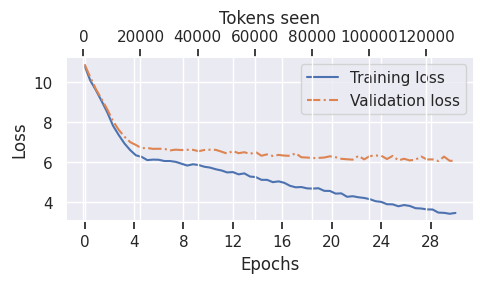

In [99]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)